In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from datetime import date
import datetime
from sklearn import set_config

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn import set_config
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

In [3]:
from sklearn import set_config
set_config(display="diagram")

In [7]:
df_main = pd.read_csv('../data/train_val_data.csv')
df_test = pd.read_csv('../data/test_data.csv')

In [8]:
df_main.rename(columns = {'annual':'salary'}, inplace = True)

In [9]:
df_main.drop(['summed_annual_salary'], inplace=True, axis = 1)
df_test.drop(['summed_annual_salary'], inplace=True, axis = 1)

In [10]:
date_ref = date(2022,1,1)

In [11]:
def experience(list_date, date_base):
    exp = []
    for date_temp in list_date:
        date_res = date_base - datetime.datetime.strptime(date_temp, '%m/%d/%y').date()
        exp.append(abs(date_res.days))       
    return exp

In [12]:
xp_main = experience(list(df_main['hire_date']), date_ref)
xp_test = experience(list(df_test['hire_date']), date_ref)

In [13]:
df_main["experience"] = xp_main
df_test["experience"] = xp_test

In [14]:
df_main['year_hire_date'] = pd.to_datetime(df_main['hire_date']).apply(lambda x: x.year)
df_test['year_hire_date'] = pd.to_datetime(df_test['hire_date']).apply(lambda x: x.year)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_main.drop(['salary'], axis=1), df_main['salary'], test_size=.1, random_state=40)

In [16]:
X = df_main.drop(['salary'], axis=1)
y = df_main['salary']

### ensemble regressor

In [21]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

In [22]:
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [23]:
from sklearn.compose import make_column_transformer
encoder = make_column_transformer(
    (one_hot, ['agency_name', 'employee_type', 'rate', 'hrswkd', 'mi', 'ethnicity', 'gender', 'experience']),
    ('passthrough', ['statenum']),
    # Last but not least, our dirty column
    (one_hot, ['class_title']),
    remainder='drop',
    )

In [24]:
# We then create a pipeline chaining our encoders to a learner
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(encoder, HistGradientBoostingRegressor())

In [17]:
pipe2 = pipeline.fit(X_train, y_train)

In [18]:
pipe2.score(X_test, y_test)

0.7842625292567951

In [50]:
salary_test_v2 = pipe2.predict(X_test)

In [17]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [54]:
r2 = metrics.r2_score(y_test, salary_test_v2)
mae = mean_absolute_error(y_test, salary_test_v2)
mse = mean_squared_error(y_test, salary_test_v2)
print("r2 : %0.1f%% " % (r2 * 100))
print("mean_absolute_error : ", mae)
print("mean_squared_error : ", mse)

r2 : 78.2% 
mean_absolute_error :  6882.38860401214
mean_squared_error :  164464218.56944296


In [45]:
salary_test_v2 = pipe2.predict(df_test)

In [23]:
salary_test_v2

array([94504.47489149, 87767.1878677 , 30768.37681199, ...,
       52675.28490463, 51344.21445666, 44751.65968198])

In [24]:
df_final_v2 = pd.DataFrame(data=salary_test_v2, columns=["predictions"])

In [25]:
df_final_v2

,predictions
0,94504.474891
1,87767.187868
2,30768.376812
3,51880.680255
4,36739.583495
...,...
20727,35213.206970
20728,66722.109224
20729,52675.284905
20730,51344.214457


In [26]:
df_final_v2.to_csv(r'../output/barre_jean_predictions_v1.csv', index=False)

In [ ]:
# SimilarityEncoder(similarity='ngram')
# TargetEncoder(handle_unknown='ignore')
# MinHashEncoder(n_components=100)
# GapEncoder(n_components=100)

In [22]:
from dirty_cat import SimilarityEncoder

In [23]:
from sklearn.compose import make_column_transformer
encoder = make_column_transformer(
    (one_hot, ['agency_name', 'employee_type', 'rate', 'hrswkd', 'mi', 'ethnicity', 'gender']),
    ('passthrough', ['statenum']),
    # Last but not least, our dirty column
    (SimilarityEncoder(similarity='ngram'), ['class_title']),
    remainder='drop',
    )

In [24]:
#pipeline = make_pipeline(encoder, HistGradientBoostingRegressor())

In [25]:
pipeline = make_pipeline(encoder, RandomForestRegressor())

In [ ]:
pipe1 = pipeline.fit(X_train, y_train)

In [ ]:
salary_predictions = pipe1.predict(X_test)

In [ ]:
print("SIMILARITY  HistGradientBoostingRegressor: \n")
r2 = metrics.r2_score(y_test, salary_predictions)
mae = mean_absolute_error(y_test, salary_predictions)
mse = mean_squared_error(y_test, salary_predictions)
print("r2 : %0.1f%% " % (r2 * 100))
print("mean_absolute_error : ", mae)
print("mean_squared_error : ", mse)
print("mean_squared_error sqrt : ", np.sqrt(mse))

In [ ]:
pipe1

In [ ]:
pipe1['columntransformer'].get_features_names_out()

In [61]:
print("SIMILARITY  RANDOM FOREST: \n")
r2 = metrics.r2_score(y_test, salary_predictions)
mae = mean_absolute_error(y_test, salary_predictions)
mse = mean_squared_error(y_test, salary_predictions)
print("r2 : %0.1f%% " % (r2 * 100))
print("mean_absolute_error : ", mae)
print("mean_squared_error : ", mse)
print("mean_squared_error sqrt : ", np.sqrt(mse))

SIMILARITY  RANDOM FOREST: 

r2 : 95.0% 
mean_absolute_error :  2908.219240911269
mean_squared_error :  37751805.38110907
mean_squared_error sqrt :  6144.249781796722


In [62]:
salary_best = pipe1.predict(df_test)
df_salary_best = pd.DataFrame(data=salary_best, columns=["predictions"])
df_salary_best.to_csv(r'../output/barre_jean_best_predictions.csv', index=False)

In [97]:
pipe1

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['agency_name',
                                                   'employee_type', 'rate',
                                                   'hrswkd', 'mi', 'ethnicity',
                                                   'gender', 'experience']),
                                                 ('passthrough', 'passthrough',
                                                  ['statenum']),
                                                 ('similarityencoder',
                                                  SimilarityEncoder(),
                                                  ['class_title'])])),
                ('randomforestregressor', RandomForestRegressor())])

In [ ]:
pipe1['columntransformer'].get_features_names()

In [128]:
feature_names_1 = pipe1['columntransformer'].transformers_[0][1].get_feature_names()

In [129]:
feature_names_2 = pipe1['columntransformer'].transformers_[2][1].get_feature_names()

In [138]:
feature_names = np.concatenate((feature_names_1, feature_names_2))

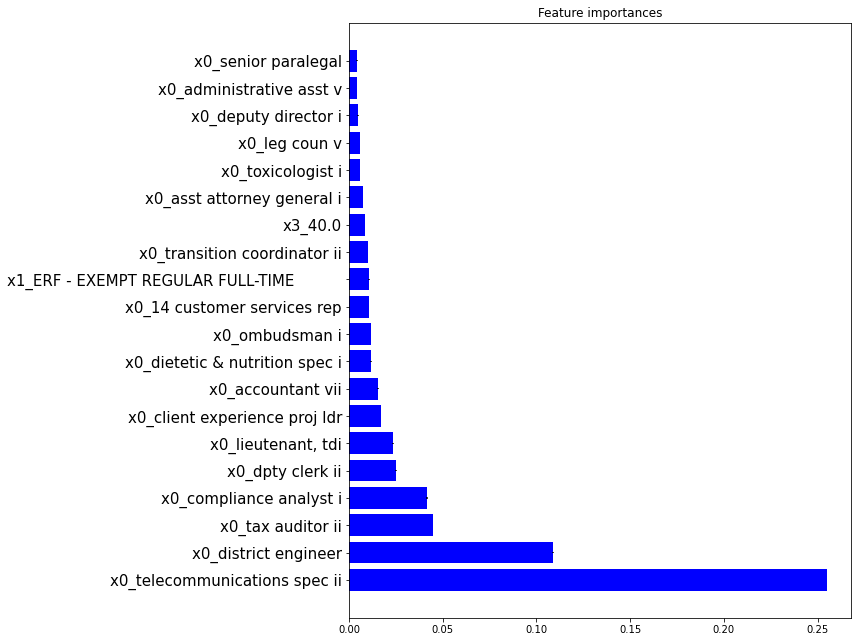

In [140]:
importances = pipe1['randomforestregressor'].feature_importances_
std = np.std(
    [
        tree.feature_importances_
        for tree in pipe1['randomforestregressor'].estimators_
    ],
    axis=0
)
indices = np.argsort(importances)
# Sort from least to most
indices = list(reversed(indices))
plt.figure(figsize=(12, 9))
plt.title("Feature importances")
n = 20
n_indices = indices[:n]
labels = np.array(feature_names)[n_indices]
plt.barh(range(n), importances[n_indices], color="b", yerr=std[n_indices])
plt.yticks(range(n), labels, size=15)
plt.tight_layout(pad=1)
plt.show()

In [151]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X, y, scoring='r2')

print(f'scores={scores}')
print(f'mean={np.mean(scores)}')
print(f'std={np.std(scores)}')

scores=[0.95038345 0.93914347 0.95154304 0.93799154 0.94105966]
mean=0.944024233991518
std=0.005761529515780691


In [48]:
print("GapEncoder")

r2 = metrics.r2_score(y_test, salary_predictions)
mae = mean_absolute_error(y_test, salary_predictions)
mse = mean_squared_error(y_test, salary_predictions)
print("r2 : %0.1f%% " % (r2 * 100))
print("mean_absolute_error : ", mae)
print("mean_squared_error : ", mse)
print("mean_squared_error sqrt : ", np.sqrt(mse))

GapEncoder
r2 : 92.9% 
mean_absolute_error :  4391.594253259706
mean_squared_error :  53495229.62416974
mean_squared_error sqrt :  7314.043315715989


In [43]:
print("MinHashEncoder")

r2 = metrics.r2_score(y_test, salary_predictions)
mae = mean_absolute_error(y_test, salary_predictions)
mse = mean_squared_error(y_test, salary_predictions)
print("r2 : %0.1f%% " % (r2 * 100))
print("mean_absolute_error : ", mae)
print("mean_squared_error : ", mse)
print("mean_squared_error sqrt : ", np.sqrt(mse))

MinHashEncoder
r2 : 93.3% 
mean_absolute_error :  3908.192700978028
mean_squared_error :  50638953.834070995
mean_squared_error sqrt :  7116.105243324539


In [38]:
print("Target Encoder")

r2 = metrics.r2_score(y_test, salary_predictions)
mae = mean_absolute_error(y_test, salary_predictions)
mse = mean_squared_error(y_test, salary_predictions)
print("r2 : %0.1f%% " % (r2 * 100))
print("mean_absolute_error : ", mae)
print("mean_squared_error : ", mse)
print("mean_squared_error sqrt : ", np.sqrt(mse))

Target Encoder
r2 : 86.6% 
mean_absolute_error :  4813.151579620319
mean_squared_error :  100879274.75547193
mean_squared_error sqrt :  10043.867519808888


In [32]:
#try with date column !!!
print("SIMILARITY : \n")
r2 = metrics.r2_score(y_test, salary_predictions)
mae = mean_absolute_error(y_test, salary_predictions)
mse = mean_squared_error(y_test, salary_predictions)
print("r2 : %0.1f%% " % (r2 * 100))
print("mean_absolute_error : ", mae)
print("mean_squared_error : ", mse)
print("mean_squared_error sqrt : ", np.sqrt(mse))

SIMILARITY : 

r2 : 94.6% 
mean_absolute_error :  3541.567312224181
mean_squared_error :  40659717.804520845
mean_squared_error sqrt :  6376.497299028742


In [27]:
salary_final = pipe1.predict(df_test)
salary_final_df = pd.DataFrame(data=salary_final, columns=["predictions"])
salary_final_df.to_csv(r'../output/barre_jean_predictions_vFBest.csv', index=False)

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [56]:
from dirty_cat import SuperVectorizer

pipeline = make_pipeline(
    SuperVectorizer(auto_cast=True),
    RandomForestRegressor()
)

In [57]:
pipeX = pipeline.fit(X_train, y_train)
pipeX.score(X_test, y_test)

0.9474773621601138

### Super Vectorizer

In [24]:
from dirty_cat import SuperVectorizer

pipeline = make_pipeline(
    SuperVectorizer(auto_cast=True),
    RandomForestRegresor()
)

In [24]:
pipe = pipeline.fit(X, y)

In [25]:
pipeX = pipeline.fit(X_train, y_train)
pipeX.score(X_test, y_test)

0.9245369441548479

In [20]:
pipe0 = pipeline.fit(X_train, y_train)

In [21]:
pipe0.score(X_test, y_test)

0.9316879261079826

In [ ]:
#weighted average - compare 

In [43]:
pipe0.score(X_test, y_test)

0.9297636113963772

In [26]:
salary_test = pipe0.predict(X_test)

In [27]:
accuracy = metrics.r2_score(y_test, salary_test)
print("Accuracy: %0.1f%% " % (accuracy * 100))

Accuracy: 92.2% 


In [31]:
mean_squared_error = metrics.mean_squared_error(y_test, salary_test)
print("mean_squared_error: ",mean_squared_error)

mean_squared_error:  58826451.85934164


In [33]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X, y, scoring='r2')

print(f'scores={scores}')
print(f'mean={np.mean(scores)}')
print(f'std={np.std(scores)}')

scores=[0.93533109 0.92455453 0.92632424 0.9239331  0.88331676]
mean=0.9186919430761431
std=0.018156853741499786


In [ ]:
salary_test = pipe0.predict(df_test)

In [27]:
salary_test

array([97922.49101014, 91627.86542003, 24806.06630872, ...,
       51130.70579546, 50200.08540035, 46814.85801104])

In [36]:
df_final_v0 = pd.DataFrame(data=salary_test, columns=["predictions"])

In [38]:
df_final_v0

,predictions
0,97922.491010
1,91627.865420
2,24806.066309
3,56878.988771
4,31576.946317
...,...
20727,31312.869658
20728,78270.574597
20729,51130.705795
20730,50200.085400


In [41]:
df_final_v0.to_csv(r'../output/barre_jean_predictions_v0.csv', index=False)

In [32]:
sup_vec = SuperVectorizer(auto_cast=True)

In [42]:
X_train_enc = sup_vec.fit_transform(X_train, y_train)
X_test_enc = sup_vec.transform(X_test)

In [43]:
X_train_enc

array([[0.0, 0.0, 0.0, ..., 40.0, 338615, 110],
       [1.0, 0.0, 0.0, ..., 40.0, 765444, 2623],
       [1.0, 0.0, 0.0, ..., 20.0, 81895, 1037],
       ...,
       [0.0, 0.0, 0.0, ..., 40.0, 206952, 3287],
       [1.0, 0.0, 0.0, ..., 40.0, 967637, 2098],
       [1.0, 0.0, 0.0, ..., 40.0, 168678, 5601]], dtype=object)

In [44]:
(X_train.shape, X_train_enc.shape)

((105729, 12), (105729, 168))

In [45]:
sup_vec.transformers_

[('low_card_cat',
  OneHotEncoder(),
  ['mi', 'ethnicity', 'gender', 'employee_type']),
 ('high_card_cat',
  GapEncoder(n_components=30),
  ['agency_name', 'class_code', 'class_title', 'hire_date']),
 ('remainder', 'passthrough', [0, 1, 2, 11])]

In [46]:
X.columns.to_list()

['rate',
 'hrswkd',
 'statenum',
 'agency_name',
 'mi',
 'class_code',
 'class_title',
 'ethnicity',
 'gender',
 'employee_type',
 'experience']

In [47]:
feature_names = sup_vec.get_feature_names()
feature_names[:8]

/home/humanum/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['mi_ ', 'mi_A', 'mi_B', 'mi_C', 'mi_D', 'mi_E', 'mi_F', 'mi_G']

In [48]:
len(feature_names)

168

In [49]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()
regressor.fit(X_train_enc, y_train)

RandomForestRegressor()

In [ ]:
regressor

In [50]:
importances = regressor.feature_importances_
std = np.std(
    [
        tree.feature_importances_
        for tree in regressor.estimators_
    ],
    axis=0
)
indices = np.argsort(importances)
# Sort from least to most
indices = list(reversed(indices))

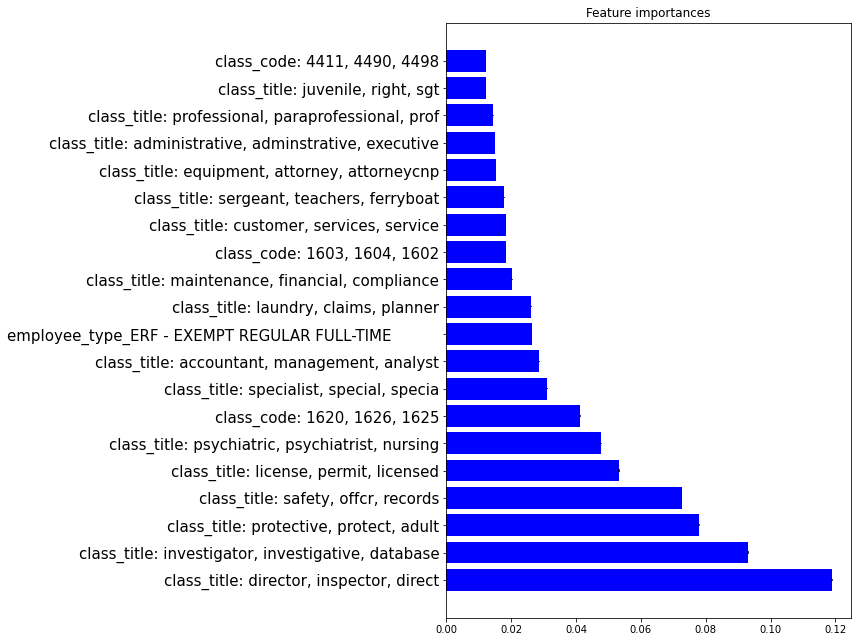

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9))
plt.title("Feature importances")
n = 20
n_indices = indices[:n]
labels = np.array(feature_names)[n_indices]
plt.barh(range(n), importances[n_indices], color="b", yerr=std[n_indices])
plt.yticks(range(n), labels, size=15)
plt.tight_layout(pad=1)
plt.show()

### Final experiments

In [27]:
from sklearn.compose import make_column_transformer

In [26]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

In [2]:
one_hot = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [25]:
from dirty_cat import SimilarityEncoder

In [33]:
encoder = make_column_transformer(
    (StandardScaler(), ['experience']),
    (one_hot, ['agency_name', 'employee_type', 'rate', 'hrswkd', 'mi', 'ethnicity', 'gender', 'year_hire_date']),
    (SimilarityEncoder(similarity='ngram'), ['class_title']),
    remainder='drop',
    )

In [40]:
#pipeline = make_pipeline(encoder, RandomForestRegressor())
pipeline = make_pipeline(encoder, HistGradientBoostingRegressor())

In [35]:
pipe_final_RF = pipeline.fit(X_train, y_train)

In [36]:
pipe_final_RF

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['experience']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['agency_name',
                                                   'employee_type', 'rate',
                                                   'hrswkd', 'mi', 'ethnicity',
                                                   'gender',
                                                   'year_hire_date']),
                                                 ('similarityencoder',
                                                  SimilarityEncoder(),
                                                  ['class_title'])])),
                ('randomforestregressor', RandomForestRegressor())])

In [37]:
pipe_final_RF.score(X_test, y_test)
salary_final_RF = pipe_final_RF.predict(X_test)

In [39]:
print("Similarity Encoder Random Forest Results")

r2 = metrics.r2_score(y_test, salary_final_RF)
mae = mean_absolute_error(y_test, salary_final_RF)
mse = mean_squared_error(y_test, salary_final_RF)
print("r2 : %0.1f%% " % (r2 * 100))
print("mean_absolute_error : ", mae)
print("mean_squared_error : ", mse)
print("mean_squared_error sqrt : ", np.sqrt(mse))

Similarity Encoder Random Forest Results
r2 : 94.9% 
mean_absolute_error :  2944.4856884023307
mean_squared_error :  38306639.24119468
mean_squared_error sqrt :  6189.235755825971


In [41]:
pipe_final_HGB = pipeline.fit(X_train, y_train)

In [42]:
pipe_final_HGB

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['experience']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['agency_name',
                                                   'employee_type', 'rate',
                                                   'hrswkd', 'mi', 'ethnicity',
                                                   'gender',
                                                   'year_hire_date']),
                                                 ('similarityencoder',
                                                  SimilarityEncoder(),
                                                  ['class_title'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor())])

In [43]:
pipe_final_HGB.score(X_test, y_test)
salary_final_HGB = pipe_final_HGB.predict(X_test)

In [44]:
print("Similarity Encoder Hist Gradient Boosting Results")

r2 = metrics.r2_score(y_test, salary_final_HGB)
mae = mean_absolute_error(y_test, salary_final_HGB)
mse = mean_squared_error(y_test, salary_final_HGB)
print("r2 : %0.1f%% " % (r2 * 100))
print("mean_absolute_error : ", mae)
print("mean_squared_error : ", mse)
print("mean_squared_error sqrt : ", np.sqrt(mse))

Similarity Encoder Hist Gradient Boosting Results
r2 : 94.6% 
mean_absolute_error :  3534.9675282449866
mean_squared_error :  40493173.219290234
mean_squared_error sqrt :  6363.424645526199


In [45]:
from dirty_cat import GapEncoder

In [47]:
encoder = make_column_transformer(
    (StandardScaler(), ['experience']),
    (one_hot, ['agency_name', 'employee_type', 'rate', 'hrswkd', 'mi', 'ethnicity', 'gender', 'year_hire_date']),
    (GapEncoder(), ['class_title']),
    remainder='drop',
    )

In [53]:
#pipeline = make_pipeline(encoder, RandomForestRegressor())
pipeline = make_pipeline(encoder, HistGradientBoostingRegressor())

In [49]:
pipe_final_GE_RF = pipeline.fit(X_train, y_train)

In [50]:
print(pipe_final_GE_RF.score(X_test, y_test))
salary_final_GE_RF = pipe_final_GE_RF.predict(X_test)

0.9250014881862263


In [52]:
print("Gap Encoder Random Forest Results")

r2 = metrics.r2_score(y_test, salary_final_GE_RF)
mae = mean_absolute_error(y_test, salary_final_GE_RF)
mse = mean_squared_error(y_test, salary_final_GE_RF)
print("r2 : %0.1f%% " % (r2 * 100))
print("mean_absolute_error : ", mae)
print("mean_squared_error : ", mse)
print("mean_squared_error sqrt : ", np.sqrt(mse))

Gap Encoder Random Forest Results
r2 : 91.2% 
mean_absolute_error :  3614.824119228167
mean_squared_error :  66075738.22844524
mean_squared_error sqrt :  8128.6984338481425


In [54]:
pipe_final_GE_HGB = pipeline.fit(X_train, y_train)

In [55]:
print(pipe_final_GE_HGB.score(X_test, y_test))
salary_final_GE_HGB = pipe_final_GE_HGB.predict(X_test)

0.8877664247410327


In [56]:
print("Gap Encoder Hist Gradient Boosting Results")

r2 = metrics.r2_score(y_test, salary_final_GE_HGB)
mae = mean_absolute_error(y_test, salary_final_GE_HGB)
mse = mean_squared_error(y_test, salary_final_GE_HGB)
print("r2 : %0.1f%% " % (r2 * 100))
print("mean_absolute_error : ", mae)
print("mean_squared_error : ", mse)
print("mean_squared_error sqrt : ", np.sqrt(mse))

Gap Encoder Hist Gradient Boosting Results
r2 : 88.8% 
mean_absolute_error :  5203.134602317052
mean_squared_error :  84785516.7130617
mean_squared_error sqrt :  9207.905120767791


In [61]:
pipe_final_RF

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['experience']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['agency_name',
                                                   'employee_type', 'rate',
                                                   'hrswkd', 'mi', 'ethnicity',
                                                   'gender',
                                                   'year_hire_date']),
                                                 ('similarityencoder',
                                                  SimilarityEncoder(),
                                                  ['class_title'])])),
                ('randomforestregressor', RandomForestRegressor())])

In [ ]:
### TODO test pipe_final_GE_RF features importances

In [62]:
feature_names = pipe_final_RF['columntransformer'].get_feature_names_out()

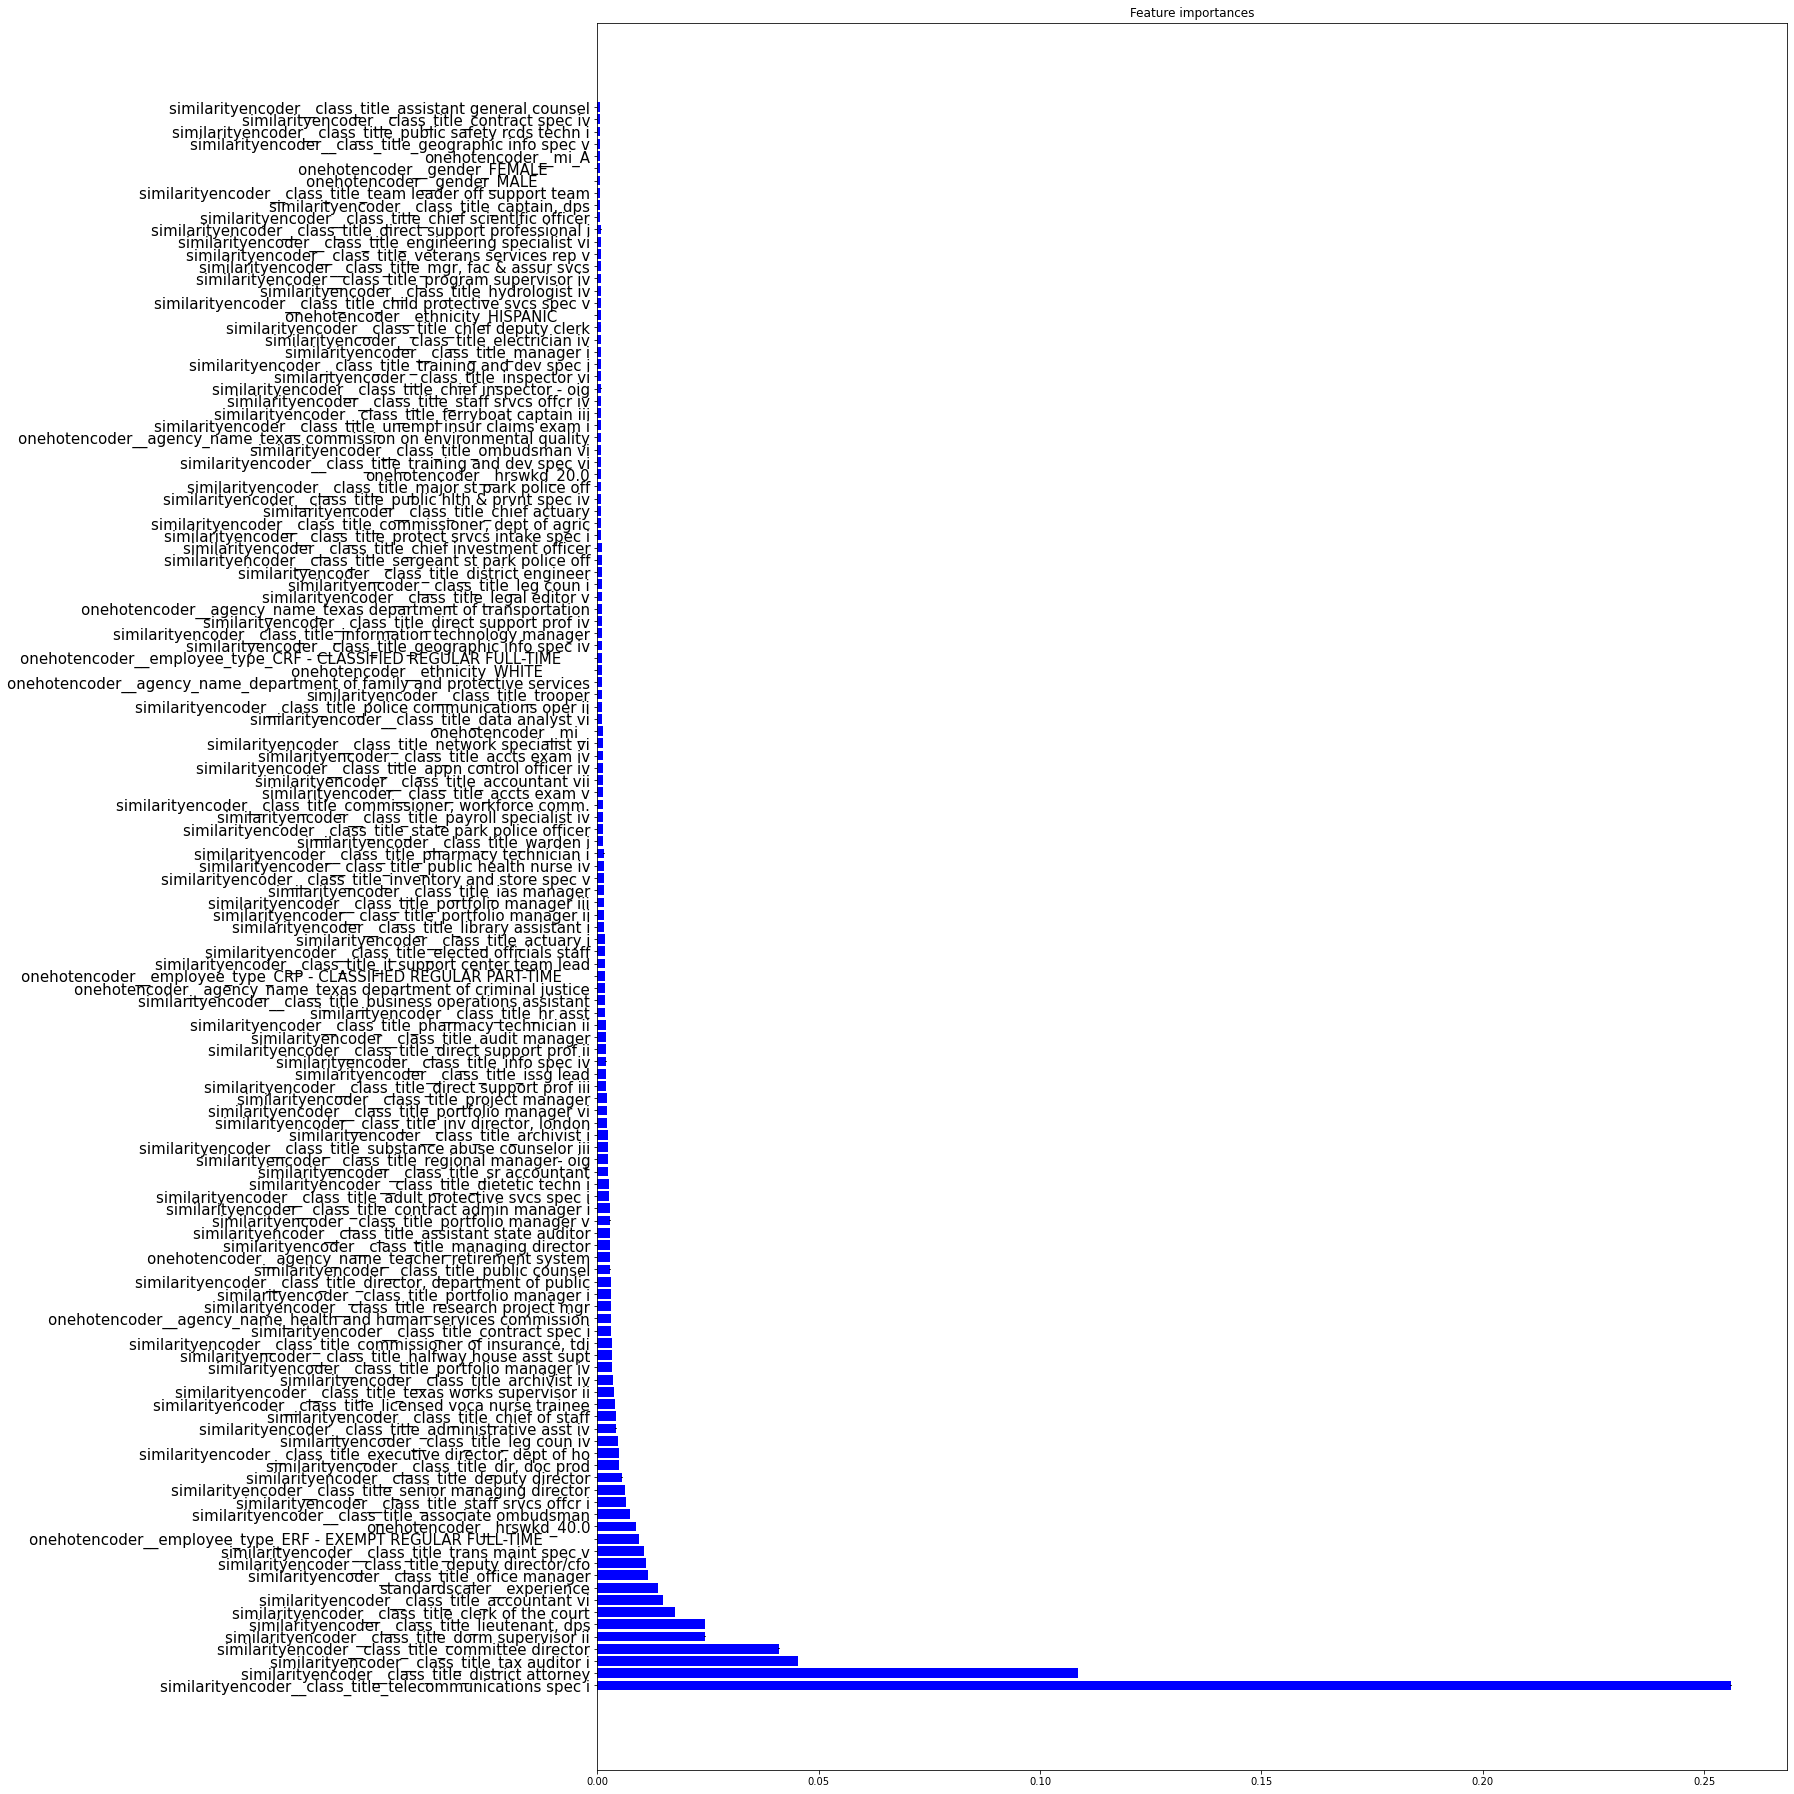

In [72]:
importances = pipe_final_RF['randomforestregressor'].feature_importances_
std = np.std(
    [
        tree.feature_importances_
        for tree in pipe_final_RF['randomforestregressor'].estimators_
    ],
    axis=0
)
indices = np.argsort(importances)
# Sort from least to most
indices = list(reversed(indices))
plt.figure(figsize=(25, 25))
plt.title("Feature importances")
n = 130
n_indices = indices[:n]
labels = np.array(feature_names)[n_indices]
plt.barh(range(n), importances[n_indices], color="b", yerr=std[n_indices])
plt.yticks(range(n), labels, size=15)
plt.tight_layout(pad=1)
plt.show()

In [73]:
salary_final = pipe_final_RF.predict(df_test)
salary_final_df = pd.DataFrame(data=salary_final, columns=["predictions"])
salary_final_df.to_csv(r'../output/barre_jean_predictions_final_RF.csv', index=False)

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe_final_RF, X, y, scoring='r2')

print(f'scores={scores}')
print(f'mean={np.mean(scores)}')
print(f'std={np.std(scores)}')

In [ ]:
#todo : grid search cv